In [44]:

import numpy as np
import matplotlib.pyplot as plt
from errorPropPendulum import *
from scipy.special import erfc                         # Error function, to get integral of Gaussian
from scipy import stats

sys.path.append('../AppStat2023/External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure


In [45]:
blind = False

if blind:
    blinding = np.random.uniform()
else:
    blinding = 0

experiment_by = ["anders", "christine", "Jakob", "makito"]

In [46]:
def Chauvenet(data): #Chauvenet med 1/4-del som kriterium frem for 1/2
    n = 1
    data_subset = data
    while n>0:
        n_bef = len(data_subset)
        mask = (len(data_subset) * erfc(abs(data_subset - data_subset.mean()) / data_subset.std(ddof=1))) >= 0.05
        data_subset = data_subset[mask]
        n = n_bef - len(data_subset)
    return data_subset, len(data)-len(data_subset)

In [47]:
# time fitting
def plot(data,minuit_chi2,res,error):
    

    def linear_func(x, a, b):
        return a*x + b
    func_linear_vec = np.vectorize(linear_func)

    # Plot data points again
    fig_fit = plt.figure(figsize=(10, 10))
    frame1 = fig_fit.add_axes((.1,.3,.8,.6))
    plt.errorbar(data[:,0],data[:,1],yerr=error,fmt=".",zorder =2,
                    color="black", label='Data')
    plt.plot(data[:,0],func_linear_vec(data[:,0], minuit_chi2.values['a'], minuit_chi2.values['b']), '-', linewidth=1,zorder=1,
                    color="blue")
    
    plt.xlabel( "Period count ",fontsize=16)
    plt.ylabel(" Time [s]",fontsize=16)
    #plt.yscale('log')
    plt.legend(fontsize=16);
    plt.grid()
    # Adding fit results to plot:
    d = {'T':       [minuit_chi2.values['a'], minuit_chi2.errors['a']],
         'Offset':       [minuit_chi2.values['b'], minuit_chi2.errors['b']],
         'Chi2':      minuit_chi2.fval,
         'ndf':       len(data[:,0])-len(minuit_chi2.values),
         'Prob':     stats.chi2.sf(minuit_chi2.fval,len(data[:,0])-len(minuit_chi2.values)),
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    def add_text_to_ax(x_coord, y_coord, string, fig,fontsize=12, color='k'):
        """ Shortcut to add text to an ax with proper font. Relative coords."""
        plt.text(x_coord, y_coord, string, family='monospace', fontsize=fontsize,
                 transform=fig.transFigure, verticalalignment='top', color=color) #
        return None
    add_text_to_ax(0.15, 0.85, text,fig_fit ,fontsize=12)
    plt.legend(loc='lower right', fontsize=18)
    
    difference = res
    frame2 = fig_fit.add_axes((.1,.1,.8,.2))        
    plt.plot(data[:,0],difference,'.', color="red", label="Residuals")
    plt.plot(data[:,0], np.zeros(len(data[:,0])), '-', linewidth=1,
                    color="black")
    plt.xlabel( "Number of periods",fontsize=16)
    plt.legend(fontsize=10)
    plt.grid()
    
    return 

In [48]:
def fit_linear(data, sy=None):
    def linear_func(x, a, b):
        return a*x + b
    
    if not sy:
        sy = np.std(data[:,1])

    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    chi2fit = Chi2Regression(linear_func, data[:,0], data[:,1], sy)
    minuit_chi2 = Minuit(chi2fit, a=3, b=-5)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();          # This is where the minimisation is carried out! Put ";" at the end to void output
    T = minuit_chi2.values["a"]
    sigmaT = minuit_chi2.errors["a"]
    offset = minuit_chi2.values["b"]
    sigma_offset = minuit_chi2.errors["b"]

    return T, sigmaT, minuit_chi2, sy#, offset, sigma_offset

def fit_gaussian(residuals):
# Define signal PDF:
    def gauss_pdf(x, mu, sigma) :
        """Gaussian"""
        return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

    def fit_pdf(x, N, mu, sigma) :
        """Gaussian"""
        return  N * binwidth * gauss_pdf(x, mu, sigma)

    # parameters for histogram
    xmin, xmax = (-0.16, 0.30)
    Nbins = 14
    binwidth = (xmax - xmin)/Nbins
    counts, bin_edges = np.histogram(residuals, bins=Nbins, range=(xmin, xmax))

    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

    chi2fit = Chi2Regression(fit_pdf, x, y, sy)
    minuit_chi2 = Minuit(chi2fit, N=np.sum(y), mu=0, sigma=1)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

    sigma = minuit_chi2.values["sigma"]
    print("std vs sigma, own std", np.std(residuals), sigma, np.sqrt(np.mean(np.abs(residuals)**2)))

    return sigma, np.std(residuals)

def find_T_sigmaT(data,name):
    def linear_func(x, a, b):
        return a*x + b

    T, sigmaT, fit_result,sy = fit_linear(data) #,offset,  sigma_offset
    residuals = linear_func(data[:,0], *fit_result.values) - data[:,1]
    sigma = fit_gaussian(residuals)[1]
    T_final, sigmaT_final, minuit_chi2, error =fit_linear(data, sigma)
    if name == "makito":
        plot(data,minuit_chi2,residuals,error)
    return fit_linear(data, sigma)#, residuals, T, sigmaT, offset, sigma_offset
    

def fit_const(data, a = None, sy = None):
    def const_func(x, a):
        return a
    
    if not a:
        a = np.mean(data)
    
    if not sy:
        sy = np.std(data)

    Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)
    chi2fit = Chi2Regression(const_func, np.arange(data.shape[0]), data, sy=sy)
    minuit_chi2 = Minuit(chi2fit, a=a)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()          
    L = minuit_chi2.values["a"]
    eL = minuit_chi2.errors["a"]
    Ndof = len(data)- len(minuit_chi2.values[:])
    prob = stats.chi2.sf(minuit_chi2.fval, Ndof)
    print(f"chi2 = {minuit_chi2.fval}, prob = {prob}, Ndof = {Ndof}")
    return L, eL


Before applying Chauvenet, laser
[1.901 1.914 1.923]
[1.822 1.815 1.819]

After applying Chauvenet, laser
[1.901 1.914 1.923]
[1.822 1.815 1.819]

Calculating L_top,laser
chi2 = 3.0000000000000004, prob = 0.22313016014842973, Ndof = 2

Calculating L_bund, laser
chi2 = 2.999999999999999, prob = 0.22313016014842993, Ndof = 2

Pendul forsøg med kort pendul, laser
L_laser = 1.8657 +- 0.0027
Before applying Chauvenet, ruler
[1.9152 1.917  1.9235 1.919 ]
[1.816  1.816  1.8228 1.816 ]

After applying Chauvenet, ruler
[1.9152 1.917  1.9235 1.919 ]
[1.816  1.816  1.8228 1.816 ]

Calculating L_top,ruler
chi2 = 3.9999999999999996, prob = 0.26146412994911106, Ndof = 3

Calculating L_bund, ruler
chi2 = 3.9999999999999996, prob = 0.26146412994911106, Ndof = 3

Pendul forsøg med kort pendul, ruler
L_ruler = 1.8682 +- 0.0011

Estimating period, T
std vs sigma, own std 0.1167251612312553 0.10607620494919671 0.11672516123125529
anders estimated: T = 2.7423281818180048 +- 0.002225860033895125, timing err

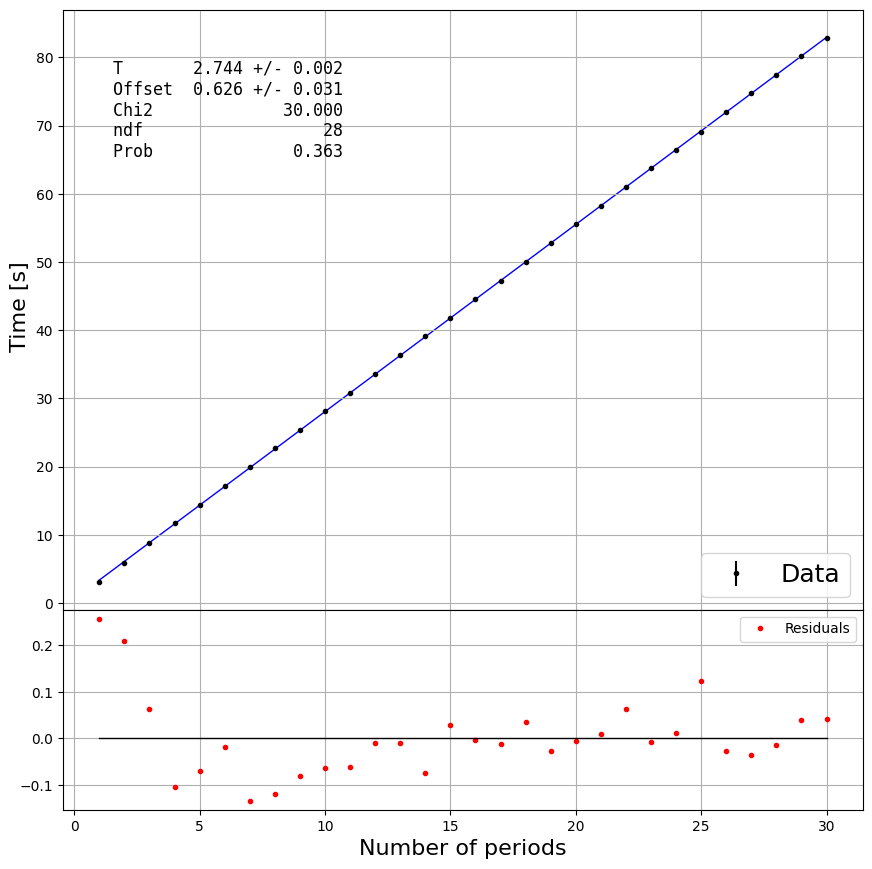

In [49]:
#Pendulforsøg 1
#Målebåndsmålinger
L_baand_bund = np.array([191.52, 191.7, 192.35, 191.9]) #i cm - rækkefølge: Anders, Makito, Jakob og Christine
L_baand_top = np.array([181.60, 181.60, 182.28, 181.6]) #i cm - rækkefølge: Anders, Makito, Jakob og Christine
L_baand_sigma = 0.1 #i cm

#Lasermålinger
L_laser_bund = np.array([2.004, 2.017, 2.026]) #i m - rækkefølge: Anders, Makito, Jakob
L_laser_top = np.array([1.925, 1.918, 1.922]) #i m - rækkefølge: Anders, Makito, Jakob
L_laser_sigma = 0.001 #i m

Laser_ejenlængde = 10.3 #i cm - medregnet i længderne ovenover

#Længden mellem loddet/pendulet og gulvet blev fastholdt i løbet af forsøget til 21.3 cm, ca. 
#Approkismativt har forsøgsopstillingen ikke ændret sig undervejs

# Afstand til masse midtpunkt antages til at være midt i loddet: pos_mid = (top + bund)/2
# emid = 1/2 sqrt(etop**2 + ebund**2)

# samler og omregner til samme enheder
L_bund_laser = L_laser_bund - Laser_ejenlængde/100
L_top_laser = L_laser_top - Laser_ejenlængde/100
L_bund_ruler = L_baand_bund/100
L_top_ruler = L_baand_top/100 


print("Before applying Chauvenet, laser")
print(L_bund_laser)
print(L_top_laser)
L_bund_ch_laser, n_bund_laser = Chauvenet(L_bund_laser) #Implermentering af Chauvenet! - Fjerner ét datum
L_top_ch_laser, n_top_laser = Chauvenet(L_top_laser) #Fjerner ingen data
print("\nAfter applying Chauvenet, laser")
print(L_bund_ch_laser)
print(L_top_ch_laser)
print("")


print("Calculating L_top,laser")
L_top_laser, eL_top_laser = fit_const(L_top_ch_laser)
print("")
print("Calculating L_bund, laser")
L_bund_laser, eL_bund_laser = fit_const(L_bund_ch_laser)

L_laser = (L_top_laser + L_bund_laser) / 2 + blinding
eL_laser = 1/2 * np.sqrt(eL_bund_laser**2 + eL_top_laser**2)
print("\nPendul forsøg med kort pendul, laser")
print(f"L_laser = {L_laser:.4f} +- {eL_laser:.4f}")

#målebånd
print("Before applying Chauvenet, ruler")
print(L_bund_ruler)
print(L_top_ruler)
L_bund_ch_ruler, n_bund_ruler = Chauvenet(L_bund_ruler) #Implermentering af Chauvenet! - Fjerner ét datum
L_top_ch_ruler, n_top_ruler = Chauvenet(L_top_ruler) #Fjerner ingen data
print("\nAfter applying Chauvenet, ruler")
print(L_bund_ch_ruler)
print(L_top_ch_ruler)
print("")


print("Calculating L_top,ruler")
L_top_ruler, eL_top_ruler = fit_const(L_top_ch_ruler)
print("")
print("Calculating L_bund, ruler")
L_bund_ruler, eL_bund_ruler = fit_const(L_bund_ch_ruler)

L_ruler = (L_top_ruler + L_bund_ruler) / 2 + blinding
eL_ruler = 1/2 * np.sqrt(eL_bund_ruler**2 + eL_top_ruler**2)
print("\nPendul forsøg med kort pendul, ruler")
print(f"L_ruler = {L_ruler:.4f} +- {eL_ruler:.4f}")


print("")
print("Estimating period, T")
T_values = np.array([])
sigmaT_values = np.array([])
timing_error = np.array([])
for person in experiment_by:
    data = np.genfromtxt(f"timedat/{person}.dat")

    if person == "anders": # Anders measured everty 5th period
        data[:,0] *= 5

    T, sigmaT, minuit_chi2,sy= find_T_sigmaT(data, person) # , offset, sigma_offset 
    T_values = np.append(T_values, T)
    sigmaT_values = np.append(sigmaT_values, sigmaT)
    timing_error = np.append(timing_error, sy)
    print(f"{person} estimated: T = {T} +- {sigmaT}, timing error: sigma = {sy}")


# weighted mean of each T values
weighted_T =  np.sum(T_values/sigmaT_values**2) / np.sum(1/sigmaT_values**2) + blinding
weighted_sigmaT = np.sqrt(1/np.sum(1/sigmaT_values**2))

print("")
print(f"T = {weighted_T:.3f} +- {weighted_sigmaT:.3f}")
print(f"Caculated value for g = {eval_g(weighted_T, L_ruler)} +- {eval_eg(L_ruler, weighted_T, eL_ruler, weighted_sigmaT)}") # using ruler 
print(f"Caculated value for g = {eval_g(weighted_T, L_laser)} +- {eval_eg(L_laser, weighted_T, eL_laser, weighted_sigmaT)}") # using laeser 

Before applying Chauvenet, laser
[18.731 18.73  18.747]
[0.398 0.398 0.403]

After applying Chauvenet, laser
[18.731 18.73  18.747]
[0.398 0.398 0.403]

Calculating L_gulv,laser
chi2 = 3.0, prob = 0.22313016014842982, Ndof = 2

Calculating L_gulv_to_bund, laser
chi2 = 3.0, prob = 0.22313016014842982, Ndof = 2


Pendul forsøg med langt pendul, laser
L_laser = 18.3363 +- 0.0047

Before applying Chauvenet, ruler
[18.327 18.319 18.33 ]
[18.314 18.312 18.313]

After applying Chauvenet, ruler
[18.327 18.319 18.33 ]
[18.314 18.312 18.313]

Calculating L_top,ruler
chi2 = 3.0, prob = 0.22313016014842982, Ndof = 2

Calculating L_bund, ruler
chi2 = 3.0, prob = 0.22313016014842982, Ndof = 2

Pendul forsøg med langt pendul, ruler
L_ruler = 18.3192 +- 0.0014

vi stoler mere på laser

Estimating period, T
std vs sigma, own std 0.11731024369069289 0.8005383400843734 0.11731024369069289
anders estimated: T = 8.587811153846523 +- 0.0032536009189039518, timing error: sigma = 0.11731024369069289
std vs si

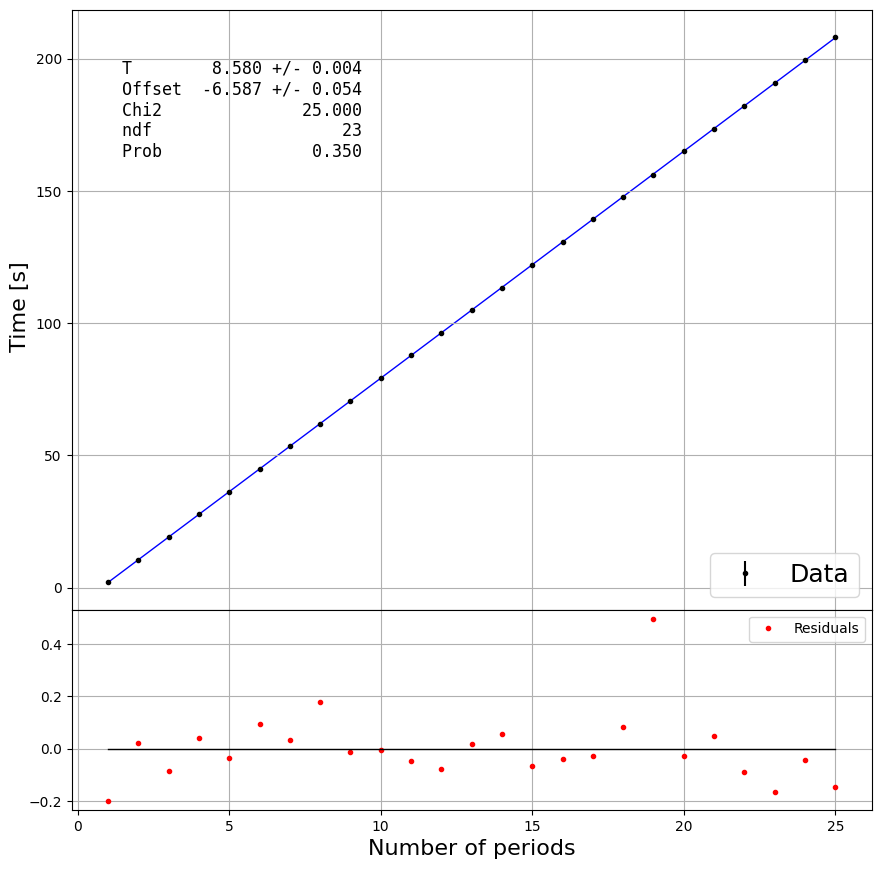

In [50]:
#Pendulforsøg 2 - langt pendul
#Maalebaandsmaalinger
LP_baand_bund = np.array([18.327, 18.319, 18.330]) #i m - rækkefølge: Anders, Makito, Jakob
LP_baand_top = np.array([18.314, 18.312, 18.313])  #i m - rækkefølge: Anders, Makito, Jakob
L_baand_sigma = 0.1 #i cm. Kommentar: Det er nok lidt for lavt ift. præcisionen af vores måling


#Lasermaalinger
LP_laser_gulv = np.array([18.731, 18.730, 18.747]) #i m - rækkefølge: Anders, Makito, Jakob
#Kommentar: I ovenstående skal laserens ejenlængde ikke trækkes fra
LP_lod_til_gulv = np.array([39.8, 39.8, 40.3]) #i cm - rækkefølge: Anders, Makito, Jakob
L_baand_sigma = 0.1 #i cm
L_laser_sigma = 0.001 #i m

# Afstand til masse midtpunkt antages til at være midt i loddet: pos_mid = (top + bund)/2
# emid = 1/2 sqrt(etop**2 + ebund**2)

# samler og omregner til samme enheder
#LP_bund = np.concatenate((LP_baand_bund, LP_laser_gulv - LP_lod_til_gulv/100))
#LP_top = LP_baand_top


# samler og omregner til samme enheder
L_gulv_laser = LP_laser_gulv 
L_gulv_to_bund_laser = LP_lod_til_gulv/100 # laser har ingen top i dette tilfælde.
L_bund_ruler = LP_baand_bund
L_top_ruler = LP_baand_top


print("Before applying Chauvenet, laser")
print(L_gulv_laser)
print(L_gulv_to_bund_laser)
L_gulv_ch_laser, n_gulv_laser = Chauvenet(L_gulv_laser) 
L_gulv_to_bund_ch_laser, n_gulv_to_bund_laser = Chauvenet(L_gulv_to_bund_laser)#Implermentering af Chauvenet! - Fjerner ét datum
print("\nAfter applying Chauvenet, laser")
print(L_gulv_ch_laser)
print(L_gulv_to_bund_ch_laser)
print("")


print("Calculating L_gulv,laser")
L_gulv_laser, eL_gulv_laser = fit_const(L_gulv_ch_laser)
print("")
print("Calculating L_gulv_to_bund, laser")
L_gulv_to_bund_laser, eL_gulv_to_bund_laser = fit_const(L_gulv_to_bund_ch_laser)

L_laser = L_gulv_laser - L_gulv_to_bund_laser + blinding
eL_laser = np.sqrt(eL_gulv_to_bund_laser **2 + eL_gulv_laser **2)
print("")
print("\nPendul forsøg med langt pendul, laser")
print(f"L_laser = {L_laser:.4f} +- {eL_laser:.4f}")
print("")
#målebånd
print("Before applying Chauvenet, ruler")
print(L_bund_ruler)
print(L_top_ruler)
L_bund_ch_ruler, n_bund_ruler = Chauvenet(L_bund_ruler) #Implermentering af Chauvenet! - Fjerner ét datum
L_top_ch_ruler, n_top_ruler = Chauvenet(L_top_ruler) #Fjerner ingen data
print("\nAfter applying Chauvenet, ruler")
print(L_bund_ch_ruler)
print(L_top_ch_ruler)
print("")


print("Calculating L_top,ruler")
L_top_ruler, eL_top_ruler = fit_const(L_top_ch_ruler)
print("")
print("Calculating L_bund, ruler")
L_bund_ruler, eL_bund_ruler = fit_const(L_bund_ch_ruler)

L_ruler = (L_top_ruler + L_bund_ruler) / 2 + blinding
eL_ruler = 1/2 * np.sqrt(eL_bund_ruler**2 + eL_top_ruler**2)
print("\nPendul forsøg med langt pendul, ruler")
print(f"L_ruler = {L_ruler:.4f} +- {eL_ruler:.4f}")
print("")
print("vi stoler mere på laser")

print("")
print("Estimating period, T")
plotting_data = 0
a_plot = np.array([])
b_plot = np.array([])
T_values = np.array([])
sigmaT_values = np.array([])
residuals_plot = np.array([])
timing_error = np.array([])
for person in experiment_by:
    if person == "Jakob": # Jakob did not participate
        continue

    data = np.genfromtxt(f"timedat/long_{person}.dat")
        

    T, sigmaT, minuit_chi2,sy = find_T_sigmaT(data, person) # , offset, sigma_offset
    T_values = np.append(T_values, T)
    sigmaT_values = np.append(sigmaT_values, sigmaT)
    timing_error = np.append(timing_error, sy)
    print(f"{person} estimated: T = {T} +- {sigmaT}, timing error: sigma = {sy}")


# weighted mean of each T values
weighted_T =  np.sum(T_values/sigmaT_values**2) / np.sum(1/sigmaT_values**2) + blinding
weighted_sigmaT = np.sqrt(1/np.sum(1/sigmaT_values**2))
print("")
print(f"T = {weighted_T:.3f} +- {weighted_sigmaT:.3f}")
print(f"Caculated value for g = {eval_g(weighted_T, L_laser)} +- {eval_eg(L_laser, weighted_T, eL_laser, weighted_sigmaT)}")

In [ ]:


# add something
